# SERVICIO DE TELEFONÍA VIRTUAL: CALLMEMAYBE

## Descripción del proyecto

### Problema central de las empresas en telecomunicaciones

La ineficacia del operador pone en riesgo la Calidad del Servicio (QoS) y la Eficiencia Operativa, dos pilares críticos para cualquier empresa de telecomunicaciones. La mala calidad del servicio, manifestada en largos tiempos de espera y llamadas perdidas, es una de las principales quejas de los clientes empresariales.

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces.
Se considera que un operador es ineficaz si:
* Tiene una gran cantidad de llamadas entrantes perdidas (internas y externas).
* Tiene un tiempo de espera prolongado para las llamadas entrantes.
* Tiene un número reducido de llamadas salientes.

### Descripción de los datos

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

OBJETIVO FINAL: Identificar y Caracterizar Operadores Ineficaces

### Descripción de los KPIs más populares

1. KPI 1: Tasa de Llamadas Perdidas -> (Llamadas Perdidas Entrantes) / (Llamadas Totales Entrantes)
2. KPI 2: Tiempo Medio de Espera por Llamada -> Promedio de (Total Duración - Duración de Conversación) para llamadas entrantes.
3. KPI 3: Tasa de Productividad Saliente -> (Llamadas Salientes Totales) / (Llamadas Totales del Operador)

* TME y Llamadas Perdidas: Son indicadores directos de Calidad del Servicio (QoS) y Eficiencia Operativa, cuyo monitoreo es el foco de los Modelos de Desempeño en telecomunicaciones.

* Baja Productividad: Un número reducido de llamadas salientes indica una baja productividad, lo cual es relevante ya que los operadores ineficaces suelen tener problemas de productividad.

## Preprocesamiento de los datos

In [1]:
#Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
#Leer documentos
df_clients = pd.read_csv('/datasets/telecom_clients_us.csv')
df_dataset = pd.read_csv('/datasets/telecom_dataset_us.csv')

In [3]:
#Explorar dataset info()
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [4]:
#Cambiar 'date' a dtype
df_dataset['date'] = pd.to_datetime(df_dataset['date'])
#ver fecha mínima y máxima
print("Mínima:", df_dataset['date'].min())
print("Máxima:", df_dataset['date'].max())

Mínima: 2019-08-02 00:00:00+03:00
Máxima: 2019-11-28 00:00:00+03:00


In [5]:
#Revisar valores nulos de la columna 'operator_id'
df_dataset['operator_id'].isna().sum()
filas_nulas = df_dataset[df_dataset['operator_id'].isnull()]
print(filas_nulas)
print()
#imprimir filas_nulas pero cuando la llamada es perdida is_missed_call=True
print(filas_nulas[filas_nulas['is_missed_call'] == True])

       user_id                      date direction internal  operator_id  \
0       166377 2019-08-04 00:00:00+03:00        in    False          NaN   
7       166377 2019-08-05 00:00:00+03:00        in    False          NaN   
9       166377 2019-08-06 00:00:00+03:00        in    False          NaN   
17      166377 2019-08-07 00:00:00+03:00        in    False          NaN   
27      166377 2019-08-12 00:00:00+03:00        in    False          NaN   
...        ...                       ...       ...      ...          ...   
53876   168601 2019-11-27 00:00:00+03:00        in    False          NaN   
53880   168601 2019-11-28 00:00:00+03:00        in    False          NaN   
53889   168603 2019-11-28 00:00:00+03:00        in    False          NaN   
53893   168606 2019-11-08 00:00:00+03:00        in    False          NaN   
53901   168606 2019-11-19 00:00:00+03:00        in    False          NaN   

       is_missed_call  calls_count  call_duration  total_call_duration  
0             

La mayoría de los valores nulos en operador_id son llamadas perdidas, quiere decir que:
* Falla del Sistema/Enrutamiento: Confirma que el operator_id nulo no se debe a un error de registro de un operador humano, sino a una llamada que se perdió en la cola o en el sistema de enrutamiento (IVR) antes de llegar a un humano.

* Limpieza Justificada: Justifica la acción de excluir estos registros del cálculo de la eficacia de los operadores individuales, ya que la responsabilidad de esa llamada perdida recae en el sistema o en la falta de capacidad general, no en un operador específico.

In [6]:
#eliminar valores nulos de operator_id
df_dataset = df_dataset.dropna(subset=['operator_id'])
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45730 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              45730 non-null  int64                                
 1   date                 45730 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            45730 non-null  object                               
 3   internal             45670 non-null  object                               
 4   operator_id          45730 non-null  float64                              
 5   is_missed_call       45730 non-null  bool                                 
 6   calls_count          45730 non-null  int64                                
 7   call_duration        45730 non-null  int64                                
 8   total_call_duration  45730 non-null  int64                                
dtypes: bool

In [7]:
#Explorar dataset describe()
df_dataset.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,45730.000000,45730.000000,45730.000000,45730.000000,45730.000000
mean,167302.220315,916535.993002,16.904417,1009.765121,1322.141789
std,600.731240,21254.123136,59.045234,4014.600085,4732.427880
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,68.000000
50%,167175.000000,913938.000000,4.000000,106.000000,290.500000
75%,167827.000000,937708.000000,14.000000,772.000000,1110.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


In [8]:
#Explorar dataset head()
df_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29


In [9]:
#Explorar clients info()
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [10]:
#Checar valores duplicados en user_id
df_clients.duplicated(subset=['user_id']).sum()

0

In [11]:
#cambiar dtype de date_start
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])
#ver fecha mínima y máxima
print("Mínima:", df_clients['date_start'].min())
print("Máxima:", df_clients['date_start'].max())

Mínima: 2019-08-01 00:00:00
Máxima: 2019-10-31 00:00:00


In [12]:
#Explorar clients describe()
df_clients.describe()

,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


In [13]:
#Explorar clients head()
df_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


<div class="alert alert-block alert-success">
<b>Comentario del revisor:</b> <a class="tocSkip"></a>
    
Has realizado un excelente trabajo al importar los datos y las bibliotecas necesarias. Además, lo complementas con el análisis de valores nulos que pudieran sesgar nuestros resultados. 

</div>

## Análisis exploratorio

In [14]:
# Unir ambos DF
df_merged = pd.merge(df_dataset, df_clients, on='user_id', how='left')
#Visualizarlos
df_merged.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29,B,2019-08-01


### Visualizar distribución de los datos

In [15]:
#Contar cuántas llamadas perdidas entrantes tiene cada operador, crear columna operator_missed_call
#Filtrar por llamadas entrantes perdidas(id_missed_call): agrupar por 'operator_id', 'direction' = in, 'calls_count'.count
df_operator_missed_call = df_merged[df_merged['is_missed_call'] == True].groupby(['operator_id', 'direction']).agg({'calls_count': 'count'}).reset_index()
print(df_operator_missed_call.head())
print()
#Filtrar por direction = in
df_operator_missed_call_in = df_operator_missed_call[df_operator_missed_call['direction'] == 'in']
print("Llamadas perdidas entrantes por operador:")
print(df_operator_missed_call_in)

   operator_id direction  calls_count
0     879896.0       out           50
1     879898.0       out          100
2     880020.0       out            7
3     880022.0       out           33
4     880026.0       out           94

Llamadas perdidas entrantes por operador:
      operator_id direction  calls_count
9        882680.0        in            3
10       882684.0        in            4
12       882686.0        in            5
15       882690.0        in            2
22       884408.0        in            3
...           ...       ...          ...
1015     959312.0        in            1
1020     960620.0        in            1
1033     964510.0        in            1
1035     964666.0        in            2
1051     969272.0        in            1

[239 rows x 3 columns]


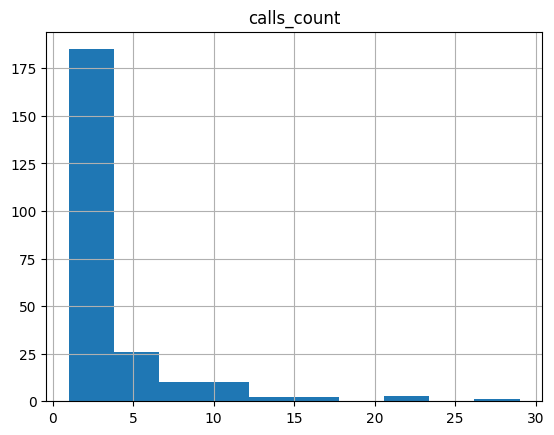

In [16]:
#Visualizar distribución de llamandas entrantes perdidas por operador: histograma
df_operator_missed_call_in.hist(column='calls_count', bins=10)
plt.show()

La mayoría de operadores tienen entre 0-5 llamandas entrantes perdidas, sin embargo algunos llegan a tener hasta 25 o más, siendo estos valores atípicos, los cuales nos interesan para identificar a los operadores ineficaces.

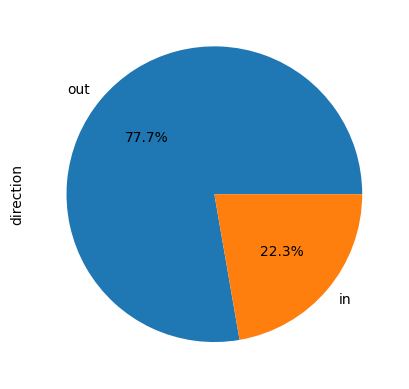

In [17]:
#Visualizar distribución de llamandas internas y externas perdidas: gráfico de pastel
df_operator_missed_call['direction'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

Obervamos que la mayoría de llamandas perdidas son salientes, lo cual es esperado en una empresa de telecomunicaciones.

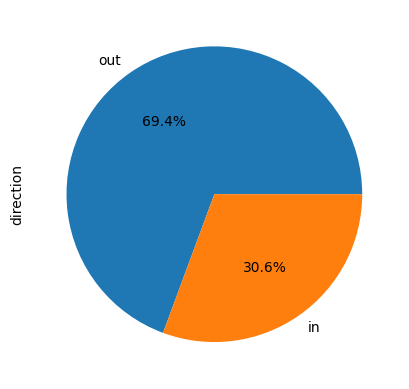

In [18]:
#Visualizar distribución de llamandas internas y externas: gráfico de pastel
df_merged['direction'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

Obervamos que la mayoría de llamandas son salientes, lo cual es esperado en una empresa de telecomunicaciones. El porcentaje de 30% de llamandas entrantes es bueno.

In [19]:
#Filtrar por tiempo de espera de llamadas entrantes
#crear columna 'tiempo_espera' (total_call_duration - call_duration)
df_merged['tiempo_espera'] = df_merged['total_call_duration'] - df_merged['call_duration']
#Obervar el tiempo de espera de cada operador en las llamandas entrantes
#agrupar por 'operator_id', 'direction' = in, 'tiempo_espera' promedio
df_operator_tiempo_espera = df_merged[df_merged['direction'] == 'in'].groupby(['operator_id', 'direction']).agg({'tiempo_espera': 'mean'}).reset_index()
print(df_operator_tiempo_espera.head())

   operator_id direction  tiempo_espera
0     879896.0        in      26.913043
1     879898.0        in      28.203125
2     880020.0        in       7.250000
3     880022.0        in      14.000000
4     880026.0        in       7.894737


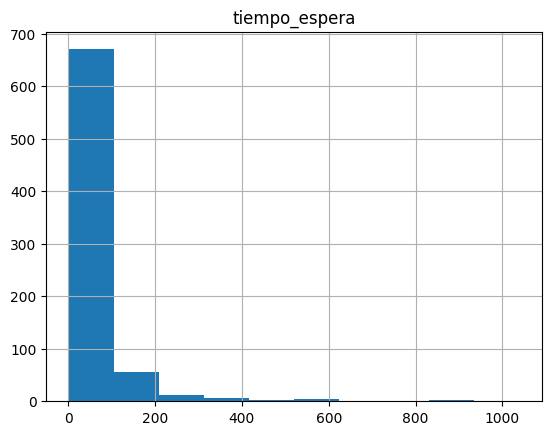

In [20]:
#Visualizar distribución de tiempo de espera en df_operator_tiempo_espera
#Histograma para tiempo de espera por llamada
df_operator_tiempo_espera.hist(column='tiempo_espera', bins=10)
plt.show()

Obervamos que la mayoría de operadores tiene un tiempo de espera en las llamadas entranres de 0-100 segundos, lo que se encuentra dentro del promedio de la industria (Tiempo Promedio de Espera (AWT) 30-60 segundos). Sin embargo los que superan los 200 segundos (3 minutos) podrían ser considerador operadores ineficaces.

      operator_id  tiempo_espera
0        879896.0          14166
1        879898.0         112972
2        880020.0            334
3        880022.0           4375
4        880026.0          23992
...           ...            ...
1087     972410.0           1498
1088     972412.0           1050
1089     972460.0            801
1090     973120.0             20
1091     973286.0             88

[1092 rows x 2 columns]
         operator_id  tiempo_espera
count    1092.000000   1.092000e+03
mean   925517.543956   1.308149e+04
std     22854.532209   7.146725e+04
min    879896.000000   0.000000e+00
25%    906393.500000   1.515000e+02
50%    925105.000000   1.113000e+03
75%    944211.500000   8.573500e+03
max    973286.000000   1.586416e+06


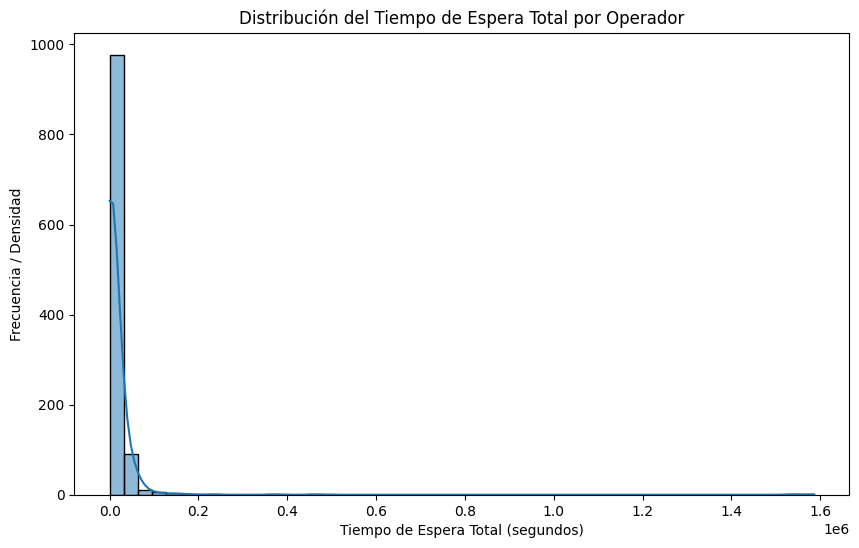

In [21]:
#Visualizar distribución de tiempo de espera por operador (sumado)
df_operator_tiempo_espera_total = df_merged.groupby(['operator_id']).agg({'tiempo_espera': 'sum'}).reset_index()
print(df_operator_tiempo_espera_total)
print(df_operator_tiempo_espera_total.describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_operator_tiempo_espera_total['tiempo_espera'], bins=50, kde=True)
plt.title('Distribución del Tiempo de Espera Total por Operador')
plt.xlabel('Tiempo de Espera Total (segundos)')
plt.ylabel('Frecuencia / Densidad')
plt.show()

De igual manera observamos los valores atípicos en los que estamos interesados, y afirmamos que la mayoría de nuestros operadores tienen tiempos de espera mínimos

   operator_id  calls_count
0     879896.0         1071
1     879898.0         7856
2     880020.0           46
3     880022.0          211
4     880026.0         2414
         operator_id   calls_count
count     882.000000    882.000000
mean   925658.340136    758.892290
std     22862.558731   3437.139515
min    879896.000000      1.000000
25%    906394.500000     13.000000
50%    924959.000000    101.000000
75%    943630.000000    656.500000
max    973120.000000  64897.000000


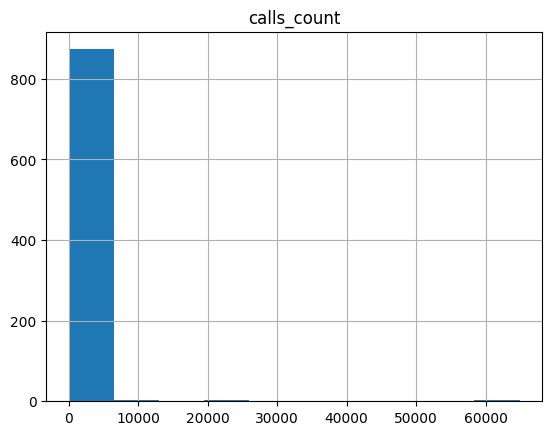

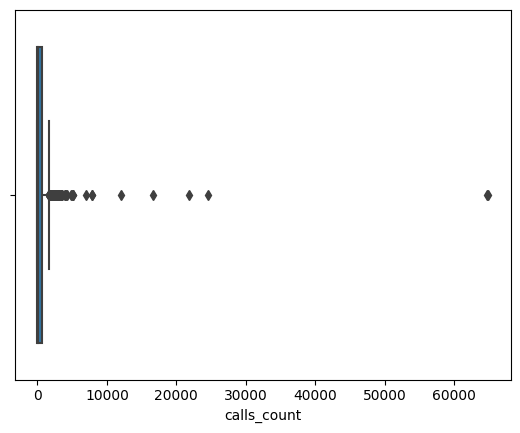

,operator_id,calls_count
544,937716.0,1
841,963716.0,1
297,914440.0,1
298,914626.0,1
710,946072.0,1
682,945274.0,1
853,966686.0,1
293,914272.0,1
858,969262.0,1
672,944560.0,1


In [22]:
#Obervar distribución de llamandas salientes por operador
#Filtrar para número de llamadas salientes
df_operator_llamadas_salientes = df_merged[df_merged['direction'] == 'out'].groupby(['operator_id']).agg({'calls_count': 'sum'}).reset_index()
print(df_operator_llamadas_salientes.head())
print(df_operator_llamadas_salientes.describe())
#Visualizar: histograma
df_operator_llamadas_salientes.hist(column='calls_count', bins=10)
plt.show()
#Visualizar: bigotes
sns.boxplot(x=df_operator_llamadas_salientes['calls_count'])
plt.show()
#Visualizar top 10 de operadores con menos llamadas salientes: los peores
df_operator_llamadas_salientes.sort_values(by='calls_count', ascending=True).head(10)

El promedio de llamandas salientes por operador es de 758, sin embargo vemos que hay operadores atípicos que realizan muchas llamandas salientes, pero vemos algunos que tienen unicamente 1 llamanda saliente, lo cual nos habla de los operadores ineficaces.

In [23]:
#Visualizar distribución de número de llamandas salientes filtrando por internas (internal= True)
df_operator_llamadas_salientes_internas = df_merged[df_merged['internal'] == True].groupby(['operator_id']).agg({'calls_count': 'sum'}).reset_index()
print(df_operator_llamadas_salientes_internas.head())
print(df_operator_llamadas_salientes_internas.describe())
#Visualizar top 10 operadores con más llamandas salientes internas
df_operator_llamadas_salientes_internas.sort_values(by='calls_count', ascending=False).head(10)

   operator_id  calls_count
0     879896.0           58
1     879898.0           19
2     880020.0            4
3     880022.0           15
4     880026.0           21
         operator_id  calls_count
count     568.000000   568.000000
mean   925776.468310    26.088028
std     23170.875963    58.768934
min    879896.000000     1.000000
25%    906368.000000     2.000000
50%    925457.000000     6.000000
75%    944644.500000    19.000000
max    972460.000000   501.000000


,operator_id,calls_count
171,907986.0,501
143,906394.0,466
136,905574.0,383
144,906396.0,333
134,905566.0,330
149,906406.0,318
21,887276.0,290
146,906400.0,272
207,915358.0,266
152,906412.0,265


Algunos operadores tienen más de 300 llamandas salientes internas, sin embargo no representan un gran porcentaje de llamadas comparado con el total

   operator_id                      date  calls_count
0     879896.0 2019-08-02 00:00:00+03:00           13
1     879896.0 2019-08-03 00:00:00+03:00           11
2     879896.0 2019-08-04 00:00:00+03:00            2
3     879896.0 2019-08-05 00:00:00+03:00           29
4     879896.0 2019-08-06 00:00:00+03:00           87
         operator_id   calls_count
count   19647.000000  19647.000000
mean   916586.159006     39.346414
std     20926.797212    126.822174
min    879896.000000      1.000000
25%    900788.000000      3.000000
50%    913942.000000      9.000000
75%    936324.000000     35.000000
max    973286.000000   5022.000000


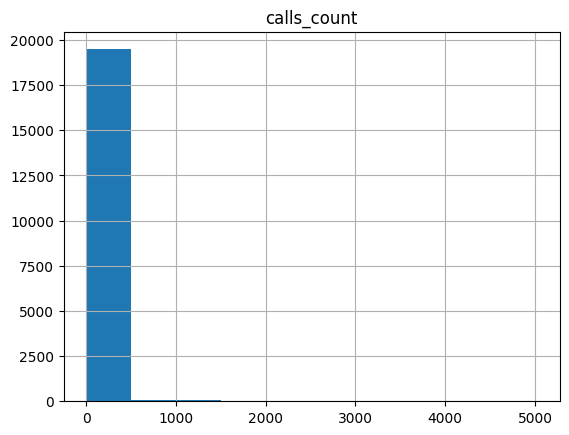

In [24]:
#filtrar por número de llamadas totales por día, por operador
df_operator_llamandas_totales = df_merged.groupby(['operator_id', 'date']).agg({'calls_count': 'sum'}).reset_index()
print(df_operator_llamandas_totales.head())
print(df_operator_llamandas_totales.describe())
#Visualizar
df_operator_llamandas_totales.hist(column='calls_count', bins=10)
plt.show()

En promedio un operador realiza 39 llamandas al día, sin embargo vemos operadores por debajo de la media, así como muchos por encima de la media. Lo que nos ayuda a identificar a los operadores ineficaces y a los más eficaces.

   operator_id  call_duration
0     879896.0     650.476562
1     879898.0    1111.067729
2     880020.0     104.090909
3     880022.0     240.842105
4     880026.0     856.939394
         operator_id  call_duration
count    1092.000000    1092.000000
mean   925517.543956     648.206312
std     22854.532209    1195.988200
min    879896.000000       0.000000
25%    906393.500000      76.655556
50%    925105.000000     239.806767
75%    944211.500000     659.824661
max    973286.000000   14620.545455


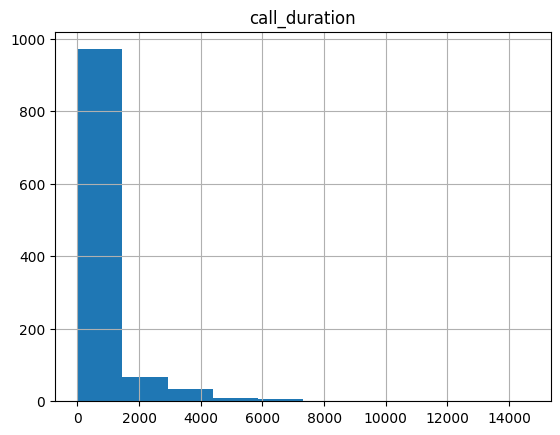

In [25]:
#Duración promedio de llamandas
df_operator_duracion_promedio = df_merged.groupby(['operator_id']).agg({'call_duration': 'mean'}).reset_index()
print(df_operator_duracion_promedio.head())
print(df_operator_duracion_promedio.describe())
#Visualizar
df_operator_duracion_promedio.hist(column='call_duration', bins=10)
plt.show()

La mayoría de llamandas duran menos de 2000 segundos, con un promedio de 648 segundos, sin embargo vemos llamandas que duran más de 6000 segundos.

In [26]:
#Duración de llamandas internas y externas: diferencia
df_operator_duracion_promedio_internas = df_merged[df_merged['internal'] == True].groupby(['operator_id']).agg({'call_duration': 'mean'}).reset_index()
print("DURACIÓN DE LLAMANDAS INTERNAS:")
print(df_operator_duracion_promedio_internas.head())
print(df_operator_duracion_promedio_internas.describe())
df_operator_duracion_promedio_externas = df_merged[df_merged['internal'] == False].groupby(['operator_id']).agg({'call_duration': 'mean'}).reset_index()
print()
print("DURACIÓN DE LLAMANDAS EXTERNAS:")
print(df_operator_duracion_promedio_externas.head())
print(df_operator_duracion_promedio_externas.describe())
#Visualizar diferencia
df_duracion_promedio_diferencia = df_operator_duracion_promedio_externas['call_duration'] - df_operator_duracion_promedio_internas['call_duration']
print(df_duracion_promedio_diferencia.describe())

DURACIÓN DE LLAMANDAS INTERNAS:
   operator_id  call_duration
0     879896.0      79.625000
1     879898.0       2.375000
2     880020.0       3.333333
3     880022.0       0.000000
4     880026.0       0.000000
         operator_id  call_duration
count     568.000000     568.000000
mean   925776.468310      64.048923
std     23170.875963     123.765884
min    879896.000000       0.000000
25%    906368.000000       0.000000
50%    925457.000000      13.000000
75%    944644.500000      76.625000
max    972460.000000    1347.800000

DURACIÓN DE LLAMANDAS EXTERNAS:
   operator_id  call_duration
0     879896.0     732.026786
1     879898.0    1191.615385
2     880020.0     120.000000
3     880022.0     269.176471
4     880026.0     922.141304
         operator_id  call_duration
count    1055.000000    1055.000000
mean   925051.124171     706.933416
std     22727.256374    1246.517781
min    879896.000000       0.000000
25%    906185.000000      94.966667
50%    924936.000000     289.666667

* DURACIÓN DE LLAMADAS INTERNAS:

Promedio: Aproximadamente 64 segundos. Las llamadas internas tienden a ser cortas.
Rango: Van desde 0 segundos hasta un máximo de casi 1348 segundos (alrededor de 22 minutos).
Distribución: La mayoría (75%) de las llamadas internas duran 76 segundos o menos, con muchas en el rango muy bajo (min, 25%, 50% cuartil).

* DURACIÓN DE LLAMADAS EXTERNAS:

Promedio: Aproximadamente 707 segundos (alrededor de 11.8 minutos), lo que es significativamente mayor que las llamadas internas.
Rango: Van desde 0 segundos hasta un máximo de casi 14713 segundos (alrededor de 245 minutos).
Distribución: La mayoría (75%) de las llamadas externas duran 726 segundos o menos, pero hay algunas llamadas extremadamente largas, como se ve en el máximo.

* DIFERENCIA (Duración Externa - Duración Interna):

Promedio: La duración promedio de las llamadas externas es aproximadamente 643 segundos más larga que la de las internas. Esto es esperado, ya que las llamadas externas suelen ser con clientes y requieren más tiempo.
Rango: Aunque la media es positiva, el valor mínimo es -1292 segundos, lo que sugiere que para algunos operadores, el promedio de sus llamadas internas es ocasionalmente más largo que el de sus llamadas externas. Esto podría ser un dato interesante a investigar si un operador pasa mucho tiempo en llamadas internas.

## Métricas para identificar operadores ineficaces

In [27]:
df_merged.head()
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45730 entries, 0 to 45729
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              45730 non-null  int64                                
 1   date                 45730 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            45730 non-null  object                               
 3   internal             45670 non-null  object                               
 4   operator_id          45730 non-null  float64                              
 5   is_missed_call       45730 non-null  bool                                 
 6   calls_count          45730 non-null  int64                                
 7   call_duration        45730 non-null  int64                                
 8   total_call_duration  45730 non-null  int64                                
 9   tariff

In [28]:
#1. filtrar y agrupar df por operadores
df_operadores_kpis = pd.DataFrame({'operator_id': df_merged['operator_id'].unique()}).set_index('operator_id')

In [29]:
#Crear columna 'tasa_llamadas_perdidas' por operador: # de llamandas perdidas entrantes (is_missed_call= True + direction = in) / # de llamandas totales entrantes (direction = in)

# Llamadas entrantes perdidas
mis_in_calls = df_merged[(df_merged['is_missed_call'] == True) & (df_merged['direction'] == 'in')].groupby('operator_id')['calls_count'].sum()

# Total de llamadas entrantes
tot_in_calls = df_merged[df_merged['direction'] == 'in'].groupby('operator_id')['calls_count'].sum()

# Unir las series para calcular la tasa
df_operadores_kpis['missed_incoming_calls'] = mis_in_calls
df_operadores_kpis['total_incoming_calls'] = tot_in_calls

# Rellenar NaN con 0 para operadores sin llamadas entrantes o perdidas
df_operadores_kpis['missed_incoming_calls'] = df_operadores_kpis['missed_incoming_calls'].fillna(0)
df_operadores_kpis['total_incoming_calls'] = df_operadores_kpis['total_incoming_calls'].fillna(0)

# Calcular la tasa de llamadas perdidas entrantes
df_operadores_kpis['tasa_llamadas_perdidas'] = df_operadores_kpis['missed_incoming_calls'] / df_operadores_kpis['total_incoming_calls']

# Manejar divisiones por cero si no hay llamadas entrantes
df_operadores_kpis['tasa_llamadas_perdidas'] = df_operadores_kpis['tasa_llamadas_perdidas'].fillna(0)

print(df_operadores_kpis[['missed_incoming_calls', 'total_incoming_calls', 'tasa_llamadas_perdidas']].head())

             missed_incoming_calls  total_incoming_calls  \
operator_id                                                
880022.0                       0.0                   8.0   
880020.0                       0.0                   8.0   
881278.0                       0.0                   0.0   
880028.0                       0.0                  70.0   
880026.0                       0.0                  25.0   

             tasa_llamadas_perdidas  
operator_id                          
880022.0                        0.0  
880020.0                        0.0  
881278.0                        0.0  
880028.0                        0.0  
880026.0                        0.0  


In [30]:
#Crear columna 'promedio_tiempo_espera' por operador: filtrar por llamandas entrantes (direction= in) y por externa (internal=False)

# Filtrar llamadas entrantes no perdidas (para calcular el tiempo de espera asociado a llamadas atendidas)
df_incoming_answered = df_merged[(df_merged['direction'] == 'in') & (df_merged['is_missed_call'] == False)].copy()

# Calcular el tiempo de espera para cada llamada
df_incoming_answered.loc[:, 'tiempo_espera_por_llamada'] = df_incoming_answered['total_call_duration'] - df_incoming_answered['call_duration']

# Calcular el promedio de tiempo de espera por operador para estas llamadas
promedio_tiempo_espera_incoming = df_incoming_answered.groupby('operator_id')['tiempo_espera_por_llamada'].mean()

# Añadir al DataFrame de KPIs
df_operadores_kpis['promedio_tiempo_espera'] = promedio_tiempo_espera_incoming

# Rellenar NaN con 0 para operadores sin llamadas entrantes atendidas
df_operadores_kpis['promedio_tiempo_espera'] = df_operadores_kpis['promedio_tiempo_espera'].fillna(0)

print(df_operadores_kpis[['promedio_tiempo_espera']].head())

             promedio_tiempo_espera
operator_id                        
880022.0                  14.000000
880020.0                   7.250000
881278.0                   0.000000
880028.0                   8.844444
880026.0                   7.894737


In [31]:
#Crear columna 'productividad_saliente' por operador: llamadas_salientes_totales / llamadas_totales

# Total de llamadas salientes por operador
tot_out_calls = df_merged[df_merged['direction'] == 'out'].groupby('operator_id')['calls_count'].sum()

# Total de llamadas de cada operador (entrantes + salientes)
tot_operator_calls = df_merged.groupby('operator_id')['calls_count'].sum()

# Unir las series para calcular la tasa
df_operadores_kpis['total_outgoing_calls'] = tot_out_calls
df_operadores_kpis['total_operator_calls'] = tot_operator_calls

# Rellenar NaN con 0 para operadores sin llamadas salientes o totales
df_operadores_kpis['total_outgoing_calls'] = df_operadores_kpis['total_outgoing_calls'].fillna(0)
df_operadores_kpis['total_operator_calls'] = df_operadores_kpis['total_operator_calls'].fillna(0)

# Calcular la tasa de productividad saliente
df_operadores_kpis['productividad_saliente'] = df_operadores_kpis['total_outgoing_calls'] / df_operadores_kpis['total_operator_calls']

# Manejar divisiones por cero si no hay llamadas totales
df_operadores_kpis['productividad_saliente'] = df_operadores_kpis['productividad_saliente'].fillna(0)

print(df_operadores_kpis[['total_outgoing_calls', 'total_operator_calls', 'productividad_saliente']].head())

             total_outgoing_calls  total_operator_calls  \
operator_id                                               
880022.0                    211.0                   219   
880020.0                     46.0                    54   
881278.0                     20.0                    20   
880028.0                   2836.0                  2906   
880026.0                   2414.0                  2439   

             productividad_saliente  
operator_id                          
880022.0                   0.963470  
880020.0                   0.851852  
881278.0                   1.000000  
880028.0                   0.975912  
880026.0                   0.989750  


### Identificación de operadores ineficaces

In [32]:
# Calcular los umbrales (percentiles)

# KPI 1: Tasa de Llamadas Perdidas (alto es malo)
umbral_tasa_perdidas = df_operadores_kpis['tasa_llamadas_perdidas'].quantile(0.75)

# KPI 2: Promedio de Tiempo de Espera (alto es malo)
umbral_tiempo_espera = df_operadores_kpis['promedio_tiempo_espera'].quantile(0.75)

# KPI 3: Productividad Saliente (bajo es malo)
umbral_productividad_saliente = df_operadores_kpis['productividad_saliente'].quantile(0.25)

print(f"Umbral Tasa de Llamadas Perdidas (P75): {umbral_tasa_perdidas:.4f}")
print(f"Umbral Promedio de Tiempo de Espera (P75): {umbral_tiempo_espera:.2f}")
print(f"Umbral Productividad Saliente (P25): {umbral_productividad_saliente:.4f}")

# Agrupar por operadores eficaces e ineficaces
# Un operador será 'ineficaz' si cumple al menos una de las condiciones de ineficacia
df_operadores_kpis['es_ineficaz'] = (
    (df_operadores_kpis['tasa_llamadas_perdidas'] > umbral_tasa_perdidas) |
    (df_operadores_kpis['promedio_tiempo_espera'] > umbral_tiempo_espera) |
    (df_operadores_kpis['productividad_saliente'] < umbral_productividad_saliente)
)

# Contar cuántos operadores son ineficaces y eficaces
print("\nDistribución de operadores:\n")
print(df_operadores_kpis['es_ineficaz'].value_counts())

# Separar los DataFrames para análisis posterior
df_ineficaces = df_operadores_kpis[df_operadores_kpis['es_ineficaz'] == True]
df_eficaces = df_operadores_kpis[df_operadores_kpis['es_ineficaz'] == False]

print("\nPrimeras 5 filas de operadores ineficaces:\n")
print(df_ineficaces.head())

Umbral Tasa de Llamadas Perdidas (P75): 0.0000
Umbral Promedio de Tiempo de Espera (P75): 44.01
Umbral Productividad Saliente (P25): 0.2377

Distribución de operadores:

False    571
True     521
Name: es_ineficaz, dtype: int64

Primeras 5 filas de operadores ineficaces:

             missed_incoming_calls  total_incoming_calls  \
operator_id                                                
882476.0                       0.0                   3.0   
886892.0                       0.0                   2.0   
891900.0                       0.0                  36.0   
891906.0                       0.0                  77.0   
886674.0                       0.0                  14.0   

             tasa_llamadas_perdidas  promedio_tiempo_espera  \
operator_id                                                   
882476.0                        0.0               31.666667   
886892.0                        0.0               58.000000   
891900.0                        0.0               70.4

In [33]:
#Observar df con número de operadores eficaces e ineficaces y sus características (describe())
print("\nEstadísticas Descriptivas para Operadores Ineficaces:\n")
print(df_ineficaces.describe())

print("\nEstadísticas Descriptivas para Operadores Eficaces:\n")
print(df_eficaces.describe())


Estadísticas Descriptivas para Operadores Ineficaces:

       missed_incoming_calls  total_incoming_calls  tasa_llamadas_perdidas  \
count             521.000000             521.00000              521.000000   
mean                1.940499             189.74856                0.024847   
std                 4.936745             463.99811                0.078209   
min                 0.000000               1.00000                0.000000   
25%                 0.000000               7.00000                0.000000   
50%                 0.000000              31.00000                0.000000   
75%                 2.000000             152.00000                0.015306   
max                55.000000            5221.00000                1.000000   

       promedio_tiempo_espera  total_outgoing_calls  total_operator_calls  \
count              521.000000            521.000000            521.000000   
mean                79.540788            596.838772            786.587332   
std       

1. Para Operadores Ineficaces:

* Tasa de Llamadas Perdidas: Tienen una media de 0.0248 (2.48%), con algunos operadores llegando hasta el 1.0 (100%), lo cual es esperable ya que este grupo incluye a los que tienen una tasa alta de llamadas perdidas.
* Promedio de Tiempo de Espera: La media es significativamente alta en 79.54 segundos, con un máximo de 1067.94 segundos. El 75% de estos operadores tienen un tiempo de espera promedio superior a 77.38 segundos, lo que los sitúa muy por encima del umbral de eficiencia.
* Productividad Saliente: La media es baja, 0.3458 (34.58%), y el 75% de estos operadores tienen una productividad saliente inferior a 0.7142. Además, el mínimo es 0.0, lo que significa que algunos operadores ineficaces no realizan ninguna llamada saliente. Esto coincide con el criterio de 'baja productividad saliente'.
* Volumen de Llamadas: Curiosamente, la media de total_operator_calls es 786.58, pero con una std muy alta, indicando una gran dispersión. Algunos ineficaces manejan muchas llamadas, pero lo hacen mal.

2. Para Operadores Eficaces:

* Tasa de Llamadas Perdidas: La media es 0.0, lo que significa que la mayoría de los operadores eficaces no tienen llamadas entrantes perdidas asignadas, o están muy por debajo del umbral.
* Promedio de Tiempo de Espera: La media es mucho menor, 8.38 segundos, y el máximo es 44.00 segundos, justo en el umbral que definimos para la ineficacia. El 75% de estos operadores tiene un promedio de tiempo de espera de 15.17 segundos o menos.
* Productividad Saliente: La media es muy alta, 0.9122 (91.22%), y el 75% de estos operadores tiene una productividad saliente de 1.0 (100%), lo que indica que realizan mayormente llamadas salientes o que su proporción de llamadas salientes respecto al total es muy alta.
* Volumen de Llamadas: La media de total_operator_calls es 636.12, similar a los ineficaces en magnitud, pero con mejor desempeño en los KPIs.

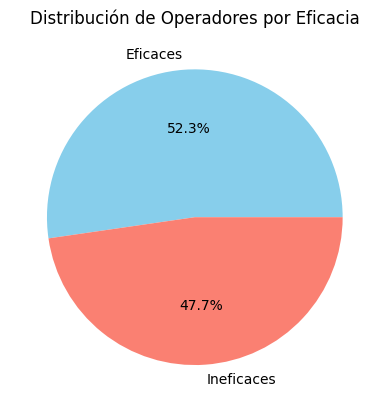

In [34]:
# Obervar porcentaje de operadores eficaces e ineficaces: gráfico de pastel

# Definir las etiquetas para el gráfico
labels = ['Eficaces', 'Ineficaces']

# Contar los valores y plotear el gráfico de pastel con título y etiquetas
df_operadores_kpis['es_ineficaz'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    labels=labels, # Asignar las etiquetas
    colors=['skyblue', 'salmon'] #asignar colores para mayor claridad
)

plt.title('Distribución de Operadores por Eficacia') # Añadir el título
plt.ylabel('') # Eliminar la etiqueta 'es_ineficaz' del eje y
plt.show()

In [35]:
# Guarda el DataFrame df_operadores_kpis en un archivo CSV.
df_operadores_kpis.to_csv('kpis_operadores_ineficaces.csv', index=True)

print("Archivo CSV generado en Colab: kpis_operadores_ineficaces.csv")

Archivo CSV generado en Colab: kpis_operadores_ineficaces.csv


### Intentar limpiando valores atípicos con IQR

In [36]:
columns_to_clean = ['calls_count', 'total_call_duration', 'tiempo_espera']
df_merged_cleaned = df_merged.copy()

for column in columns_to_clean:
    Q1 = df_merged_cleaned[column].quantile(0.25)
    Q3 = df_merged_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_merged_cleaned = df_merged_cleaned[(df_merged_cleaned[column] >= lower_bound) & (df_merged_cleaned[column] <= upper_bound)]

print(f"Shape of original DataFrame: {df_merged.shape}")
print(f"Shape of cleaned DataFrame: {df_merged_cleaned.shape}")
print("Outliers removed from 'calls_count', 'total_call_duration', and 'tiempo_espera' columns.")

Shape of original DataFrame: (45730, 12)
Shape of cleaned DataFrame: (32456, 12)
Outliers removed from 'calls_count', 'total_call_duration', and 'tiempo_espera' columns.


In [37]:
columns_to_clean = ['calls_count', 'total_call_duration', 'tiempo_espera']
df_merged_cleaned = df_merged.copy()

for column in columns_to_clean:
    Q1 = df_merged_cleaned[column].quantile(0.25)
    Q3 = df_merged_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_merged_cleaned = df_merged_cleaned[(df_merged_cleaned[column] >= lower_bound) & (df_merged_cleaned[column] <= upper_bound)]

print(f"Shape of original DataFrame: {df_merged.shape}")
print(f"Shape of cleaned DataFrame: {df_merged_cleaned.shape}")
print("Outliers removed from 'calls_count', 'total_call_duration', and 'tiempo_espera' columns.")

Shape of original DataFrame: (45730, 12)
Shape of cleaned DataFrame: (32456, 12)
Outliers removed from 'calls_count', 'total_call_duration', and 'tiempo_espera' columns.


In [38]:
df_operadores_kpis_cleaned = pd.DataFrame({'operator_id': df_merged_cleaned['operator_id'].unique()}).set_index('operator_id')

# Calculate total calls_count, total_call_duration, and tiempo_espera for each operator
df_operadores_kpis_cleaned['calls_count'] = df_merged_cleaned.groupby('operator_id')['calls_count'].sum()
df_operadores_kpis_cleaned['total_call_duration'] = df_merged_cleaned.groupby('operator_id')['total_call_duration'].sum()
df_operadores_kpis_cleaned['tiempo_espera'] = df_merged_cleaned.groupby('operator_id')['tiempo_espera'].sum()

print("df_operadores_kpis_cleaned initialized and basic aggregations calculated:")
print(df_operadores_kpis_cleaned.head())

df_operadores_kpis_cleaned initialized and basic aggregations calculated:
             calls_count  total_call_duration  tiempo_espera
operator_id                                                 
880022.0             168                15811           2329
880020.0              54                 2624            334
881278.0              20                  543             78
880028.0             630                37936           8081
880026.0             796                40585           8784


In [39]:
# 3. Recalculate 'tasa_llamadas_perdidas'
# Llamadas entrantes perdidas
mis_in_calls_cleaned = df_merged_cleaned[(df_merged_cleaned['is_missed_call'] == True) & (df_merged_cleaned['direction'] == 'in')].groupby('operator_id')['calls_count'].sum()

# Total de llamadas entrantes
tot_in_calls_cleaned = df_merged_cleaned[df_merged_cleaned['direction'] == 'in'].groupby('operator_id')['calls_count'].sum()

# Unir las series para calcular la tasa
df_operadores_kpis_cleaned['missed_incoming_calls'] = mis_in_calls_cleaned
df_operadores_kpis_cleaned['total_incoming_calls'] = tot_in_calls_cleaned

# Rellenar NaN con 0 para operadores sin llamadas entrantes o perdidas
df_operadores_kpis_cleaned['missed_incoming_calls'] = df_operadores_kpis_cleaned['missed_incoming_calls'].fillna(0)
df_operadores_kpis_cleaned['total_incoming_calls'] = df_operadores_kpis_cleaned['total_incoming_calls'].fillna(0)

# Calcular la tasa de llamadas perdidas entrantes
df_operadores_kpis_cleaned['tasa_llamadas_perdidas'] = df_operadores_kpis_cleaned['missed_incoming_calls'] / df_operadores_kpis_cleaned['total_incoming_calls']

# Manejar divisiones por cero si no hay llamadas entrantes
df_operadores_kpis_cleaned['tasa_llamadas_perdidas'] = df_operadores_kpis_cleaned['tasa_llamadas_perdidas'].fillna(0)

# 4. Recalculate 'promedio_tiempo_espera'
# Filtrar llamadas entrantes no perdidas (para calcular el tiempo de espera asociado a llamadas atendidas)
df_incoming_answered_cleaned = df_merged_cleaned[(df_merged_cleaned['direction'] == 'in') & (df_merged_cleaned['is_missed_call'] == False)].copy()

# Calcular el tiempo de espera para cada llamada
df_incoming_answered_cleaned.loc[:, 'tiempo_espera_por_llamada'] = df_incoming_answered_cleaned['total_call_duration'] - df_incoming_answered_cleaned['call_duration']

# Calcular el promedio de tiempo de espera por operador para estas llamadas
promedio_tiempo_espera_incoming_cleaned = df_incoming_answered_cleaned.groupby('operator_id')['tiempo_espera_por_llamada'].mean()

# Añadir al DataFrame de KPIs
df_operadores_kpis_cleaned['promedio_tiempo_espera'] = promedio_tiempo_espera_incoming_cleaned

# Rellenar NaN con 0 para operadores sin llamadas entrantes atendidas
df_operadores_kpis_cleaned['promedio_tiempo_espera'] = df_operadores_kpis_cleaned['promedio_tiempo_espera'].fillna(0)

# 5. Recalculate 'productividad_saliente'
# Total de llamadas salientes por operador
tot_out_calls_cleaned = df_merged_cleaned[df_merged_cleaned['direction'] == 'out'].groupby('operator_id')['calls_count'].sum()

# Total de llamadas de cada operador (entrantes + salientes)
tot_operator_calls_cleaned = df_merged_cleaned.groupby('operator_id')['calls_count'].sum()

# Unir las series para calcular la tasa
df_operadores_kpis_cleaned['total_outgoing_calls'] = tot_out_calls_cleaned
df_operadores_kpis_cleaned['total_operator_calls'] = tot_operator_calls_cleaned

# Rellenar NaN con 0 para operadores sin llamadas salientes o totales
df_operadores_kpis_cleaned['total_outgoing_calls'] = df_operadores_kpis_cleaned['total_outgoing_calls'].fillna(0)
df_operadores_kpis_cleaned['total_operator_calls'] = df_operadores_kpis_cleaned['total_operator_calls'].fillna(0)

# Calcular la tasa de productividad saliente
df_operadores_kpis_cleaned['productividad_saliente'] = df_operadores_kpis_cleaned['total_outgoing_calls'] / df_operadores_kpis_cleaned['total_operator_calls']

# Manejar divisiones por cero si no hay llamadas totales
df_operadores_kpis_cleaned['productividad_saliente'] = df_operadores_kpis_cleaned['productividad_saliente'].fillna(0)

# 6. Calculate new inefficiency thresholds
# KPI 1: Tasa de Llamadas Perdidas (alto es malo)
umbral_tasa_perdidas_cleaned = df_operadores_kpis_cleaned['tasa_llamadas_perdidas'].quantile(0.75)

# KPI 2: Promedio de Tiempo de Espera (alto es malo)
umbral_tiempo_espera_cleaned = df_operadores_kpis_cleaned['promedio_tiempo_espera'].quantile(0.75)

# KPI 3: Productividad Saliente (bajo es malo)
umbral_productividad_saliente_cleaned = df_operadores_kpis_cleaned['productividad_saliente'].quantile(0.25)

print("KPIs and thresholds recalculated for df_operadores_kpis_cleaned:")
print(df_operadores_kpis_cleaned.head())
print(f"\nNew Umbral Tasa de Llamadas Perdidas (P75): {umbral_tasa_perdidas_cleaned:.4f}")
print(f"New Umbral Promedio de Tiempo de Espera (P75): {umbral_tiempo_espera_cleaned:.2f}")
print(f"New Umbral Productividad Saliente (P25): {umbral_productividad_saliente_cleaned:.4f}")

KPIs and thresholds recalculated for df_operadores_kpis_cleaned:
             calls_count  total_call_duration  tiempo_espera  \
operator_id                                                    
880022.0             168                15811           2329   
880020.0              54                 2624            334   
881278.0              20                  543             78   
880028.0             630                37936           8081   
880026.0             796                40585           8784   

             missed_incoming_calls  total_incoming_calls  \
operator_id                                                
880022.0                       0.0                   8.0   
880020.0                       0.0                   8.0   
881278.0                       0.0                   0.0   
880028.0                       0.0                  70.0   
880026.0                       0.0                  25.0   

             tasa_llamadas_perdidas  promedio_tiempo_espera  \
op

In [40]:
df_operadores_kpis_cleaned['es_ineficaz'] = (
    (df_operadores_kpis_cleaned['tasa_llamadas_perdidas'] > umbral_tasa_perdidas_cleaned) |
    (df_operadores_kpis_cleaned['promedio_tiempo_espera'] > umbral_tiempo_espera_cleaned) |
    (df_operadores_kpis_cleaned['productividad_saliente'] < umbral_productividad_saliente_cleaned)
)

# Contar cuántos operadores son ineficaces y eficaces
print("\nDistribución de operadores:\n")
print(df_operadores_kpis_cleaned['es_ineficaz'].value_counts())

# Separar los DataFrames para análisis posterior
df_ineficaces_cleaned = df_operadores_kpis_cleaned[df_operadores_kpis_cleaned['es_ineficaz'] == True]
df_eficaces_cleaned = df_operadores_kpis_cleaned[df_operadores_kpis_cleaned['es_ineficaz'] == False]

print("\nPrimeras 5 filas de operadores ineficaces (cleaned):\n")
print(df_ineficaces_cleaned.head())


Distribución de operadores:

False    536
True     526
Name: es_ineficaz, dtype: int64

Primeras 5 filas de operadores ineficaces (cleaned):

             calls_count  total_call_duration  tiempo_espera  \
operator_id                                                    
882476.0               3                  287             95   
886892.0               2                  130             58   
891900.0              36                 5753           1338   
891906.0              77                17000           2043   
886674.0              14                  378            193   

             missed_incoming_calls  total_incoming_calls  \
operator_id                                                
882476.0                       0.0                   3.0   
886892.0                       0.0                   2.0   
891900.0                       0.0                  36.0   
891906.0                       0.0                  77.0   
886674.0                       0.0              

Los cambios no son significativos, por lo tanto trabajaremos con los originales

## Pruebas de hipótesis estadística

Pregunta 1: ¿Los operadores ineficaces manejan un volumen total de llamadas diferente al de los operadores eficaces?

* Hipótesis Nula ($H_0$): El número promedio total de llamadas al día es el mismo para los operadores ineficaces y los eficaces.
* Hipótesis Alternativa ($H_1$): El número promedio total de llamadas al día es menor para los operadores ineficaces.

In [41]:
# Datos para la prueba de hipótesis 1
# Filtrar las llamadas totales de los operadores ineficaces y eficaces
llamadas_ineficaces = df_ineficaces['total_operator_calls']
llamadas_eficaces = df_eficaces['total_operator_calls']

# Realizar la prueba t de Student para dos muestras independientes
# Como la hipótesis alternativa es que el promedio de ineficaces es MENOR, es una prueba de una cola.
# stats.ttest_ind devuelve un p-valor de dos colas, así que lo dividimos por 2 para una cola.
statistic, p_value = stats.ttest_ind(llamadas_ineficaces, llamadas_eficaces, equal_var=False, alternative='less')

print(f"Estadístico t: {statistic:.4f}")
print(f"P-valor: {p_value:.4f}")

# Nivel de significancia
alpha = 0.05

# Conclusión
if p_value < alpha:
    print(f"\nDado que el p-valor ({p_value:.4f}) es menor que el nivel de significancia ({alpha}), rechazamos la hipótesis nula.")
    print("Conclusión: Hay evidencia estadística para afirmar que el número promedio total de llamadas es menor para los operadores ineficaces que para los eficaces.")
elif p_value == 0:
    print(f"\nDado que el p-valor ({p_value:.4f}) es igual a cero (lo que significa que es extremadamente pequeño y mucho menor que el nivel de significancia ({alpha})), rechazamos la hipótesis nula.")
    print("Conclusión: Hay evidencia estadística para afirmar que el número promedio total de llamadas es menor para los operadores ineficaces que para los eficaces.")
else:
    print(f"\nDado que el p-valor ({p_value:.4f}) es mayor que el nivel de significancia ({alpha}), no rechazamos la hipótesis nula.")
    print("Conclusión: No hay evidencia estadística suficiente para afirmar que el número promedio total de llamadas es menor para los operadores ineficaces que para los eficaces.")

# Imprimir medias para contexto
print(f"\nMedia de llamadas totales para operadores ineficaces: {llamadas_ineficaces.mean():.2f}")
print(f"Media de llamadas totales para operadores eficaces: {llamadas_eficaces.mean():.2f}")

Estadístico t: 0.7544
P-valor: 0.7746

Dado que el p-valor (0.7746) es mayor que el nivel de significancia (0.05), no rechazamos la hipótesis nula.
Conclusión: No hay evidencia estadística suficiente para afirmar que el número promedio total de llamadas es menor para los operadores ineficaces que para los eficaces.

Media de llamadas totales para operadores ineficaces: 786.59
Media de llamadas totales para operadores eficaces: 636.12


Pregunta 2: ¿Los operadores ineficaces están dedicando demasiado tiempo a llamadas internas o de coordinación, desviando recursos de las interacciones con el cliente?

* Hipótesis Nula ($H_0$): La proporción de llamadas internas es la misma para los operadores ineficaces y los eficaces.
* Hipótesis Alternativa ($H_1$): La proporción de llamadas internas es mayor para los operadores ineficaces.

In [42]:
# Calcular el número total de llamadas internas por operador
total_internal_calls_per_operator = df_merged[df_merged['internal'] == True].groupby('operator_id')['calls_count'].sum()

# Calcular el número total de llamadas por operador
total_calls_per_operator = df_merged.groupby('operator_id')['calls_count'].sum()

# Calcular la proporción de llamadas internas por operador
proportion_internal_calls = (total_internal_calls_per_operator / total_calls_per_operator).fillna(0)

# Unir las proporciones al DataFrame de KPIs para facilitar la segmentación
df_operadores_kpis['proportion_internal_calls'] = proportion_internal_calls

# Segmentar las proporciones para operadores ineficaces y eficaces
proportion_internal_ineficaces = df_operadores_kpis[df_operadores_kpis['es_ineficaz'] == True]['proportion_internal_calls'].dropna()
proportion_internal_eficaces = df_operadores_kpis[df_operadores_kpis['es_ineficaz'] == False]['proportion_internal_calls'].dropna()

# Realizar la prueba t de Student para dos muestras independientes
# Hipótesis alternativa: la proporción de llamadas internas es MAYOR para los ineficaces (prueba de una cola).
statistic, p_value = stats.ttest_ind(proportion_internal_ineficaces, proportion_internal_eficaces, equal_var=False, alternative='greater')

print(f"Estadístico t: {statistic:.4f}")
print(f"P-valor: {p_value:.4f}")

# Nivel de significancia
alpha = 0.05

# Conclusión
if p_value < alpha:
    print(f"\nDado que el p-valor ({p_value:.4f}) es menor que el nivel de significancia ({alpha}), rechazamos la hipótesis nula.")
    print("Conclusión: Hay evidencia estadística para afirmar que la proporción de llamadas internas es mayor para los operadores ineficaces que para los eficaces.")
else:
    print(f"\nDado que el p-valor ({p_value:.4f}) es mayor que el nivel de significancia ({alpha}), no rechazamos la hipótesis nula.")
    print("Conclusión: No hay evidencia estadística suficiente para afirmar que la proporción de llamadas internas es mayor para los operadores ineficaces que para los eficaces.")

# Imprimir medias para contexto
print(f"\nMedia de proporción de llamadas internas para operadores ineficaces: {proportion_internal_ineficaces.mean():.4f}")
print(f"Media de proporción de llamadas internas para operadores eficaces: {proportion_internal_eficaces.mean():.4f}")

Estadístico t: -6.2283
P-valor: 1.0000

Dado que el p-valor (1.0000) es mayor que el nivel de significancia (0.05), no rechazamos la hipótesis nula.
Conclusión: No hay evidencia estadística suficiente para afirmar que la proporción de llamadas internas es mayor para los operadores ineficaces que para los eficaces.

Media de proporción de llamadas internas para operadores ineficaces: 0.0725
Media de proporción de llamadas internas para operadores eficaces: 0.1671


Pregunta 3: ¿El tiempo que los operadores pasan realmente en conversación (call_duration) difiere entre los dos grupos?

* Hipótesis Nula ($H_0$): La duración media de la llamada de conversación (call_duration) para las llamadas no perdidas es la misma para ambos grupos.
* Hipótesis Alternativa ($H_1$): La duración media de la llamada de conversación es menor para los operadores ineficaces.

In [43]:
# Filtrar llamadas no perdidas (para la duración de la conversación real)
df_answered_calls = df_merged[df_merged['is_missed_call'] == False].copy()

# Calcular la duración media de la llamada de conversación por operador para estas llamadas
mean_call_duration_answered = df_answered_calls.groupby('operator_id')['call_duration'].mean()

# Añadir al DataFrame de KPIs
df_operadores_kpis['mean_answered_call_duration'] = mean_call_duration_answered

# Rellenar NaN con 0 para operadores que no tuvieron llamadas contestadas (aunque esto debería ser raro si tienen actividad)
df_operadores_kpis['mean_answered_call_duration'] = df_operadores_kpis['mean_answered_call_duration'].fillna(0)

# Segmentar las duraciones medias de llamada para operadores ineficaces y eficaces
mean_duration_ineficaces = df_operadores_kpis[df_operadores_kpis['es_ineficaz'] == True]['mean_answered_call_duration'].dropna()
mean_duration_eficaces = df_operadores_kpis[df_operadores_kpis['es_ineficaz'] == False]['mean_answered_call_duration'].dropna()

# Realizar la prueba t de Student para dos muestras independientes
# Hipótesis alternativa: la duración media es MENOR para los ineficaces (prueba de una cola).
statistic, p_value = stats.ttest_ind(mean_duration_ineficaces, mean_duration_eficaces, equal_var=False, alternative='less')

print(f"Estadístico t: {statistic:.4f}")
print(f"P-valor: {p_value:.4f}")

# Nivel de significancia
alpha = 0.05

# Conclusión
if p_value < alpha:
    print(f"\nDado que el p-valor ({p_value:.4f}) es menor que el nivel de significancia ({alpha}), rechazamos la hipótesis nula.")
    print("Conclusión: Hay evidencia estadística para afirmar que la duración media de la llamada de conversación es menor para los operadores ineficaces que para los eficaces.")
else:
    print(f"\nDado que el p-valor ({p_value:.4f}) es mayor que el nivel de significancia ({alpha}), no rechazamos la hipótesis nula.")
    print("Conclusión: No hay evidencia estadística suficiente para afirmar que la duración media de la llamada de conversación es menor para los operadores ineficaces que para los eficaces.")

# Imprimir medias para contexto
print(f"\nMedia de duración de llamadas contestadas para operadores ineficaces: {mean_duration_ineficaces.mean():.2f}")
print(f"Media de duración de llamadas contestadas para operadores eficaces: {mean_duration_eficaces.mean():.2f}")

Estadístico t: -5.4287
P-valor: 0.0000

Dado que el p-valor (0.0000) es menor que el nivel de significancia (0.05), rechazamos la hipótesis nula.
Conclusión: Hay evidencia estadística para afirmar que la duración media de la llamada de conversación es menor para los operadores ineficaces que para los eficaces.

Media de duración de llamadas contestadas para operadores ineficaces: 755.11
Media de duración de llamadas contestadas para operadores eficaces: 1479.60


Pregunta 4: ¿Los operadores ineficaces están asignados desproporcionadamente a cuentas de clientes con ciertos planes tarifarios (por ejemplo, planes "Premium" o planes de "Bajo Costo")?

* Hipótesis Nula ($H_0$): El plan tarifario de los clientes asignados a operadores ineficaces está distribuido de la misma manera que para los operadores eficaces.
* Hipótesis Alternativa ($H_1$): La distribución de los planes tarifarios es diferente entre los dos grupos de operadores.

In [44]:
# Unir df_merged con el estado de ineficacia de cada operador
df_temp = df_merged.merge(
    df_operadores_kpis[['es_ineficaz']],
    left_on='operator_id',
    right_index=True,
    how='left'
)

# Asegurarse de que 'es_ineficaz' no tenga nulos (operadores que no estaban en df_operadores_kpis)
df_temp['es_ineficaz'] = df_temp['es_ineficaz'].fillna(False) # Asumimos que si no está en la lista de KPIs, no es ineficaz

# Crear la tabla de contingencia
# Contamos el número de llamadas ('calls_count') para cada combinación de plan tarifario y estado de ineficacia del operador.
contingency_table = pd.crosstab(df_temp['tariff_plan'], df_temp['es_ineficaz'], values=df_temp['calls_count'], aggfunc='sum').fillna(0)

# Renombrar columnas para claridad
contingency_table.columns = ['Eficaces' if col == False else 'Ineficaces' for col in contingency_table.columns]

print("Tabla de Contingencia (Recuento de Llamadas por Plan Tarifario y Eficacia del Operador):\n")
print(contingency_table)

# Realizar la prueba de Chi-cuadrado
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nEstadístico Chi-cuadrado: {chi2:.4f}")
print(f"P-valor: {p_value:.4f}")
print(f"Grados de Libertad (dof): {dof}")
# print("Frecuencias Esperadas:\n", expected)

# Nivel de significancia
alpha = 0.05

# Conclusión
if p_value < alpha:
    print(f"\nDado que el p-valor ({p_value:.4f}) es menor que el nivel de significancia ({alpha}), rechazamos la hipótesis nula.")
    print("Conclusión: Hay evidencia estadística para afirmar que la distribución de los planes tarifarios de las llamadas es diferente entre los operadores ineficaces y los eficaces.")
else:
    print(f"\nDado que el p-valor ({p_value:.4f}) es mayor que el nivel de significancia ({alpha}), no rechazamos la hipótesis nula.")
    print("Conclusión: No hay evidencia estadística suficiente para afirmar que la distribución de los planes tarifarios de las llamadas es diferente entre los operadores ineficaces y los eficaces.")


Tabla de Contingencia (Recuento de Llamadas por Plan Tarifario y Eficacia del Operador):

             Eficaces  Ineficaces
tariff_plan                      
A              197119      223439
B               75959       76416
C               90149      109957

Estadístico Chi-cuadrado: 804.9244
P-valor: 0.0000
Grados de Libertad (dof): 2

Dado que el p-valor (0.0000) es menor que el nivel de significancia (0.05), rechazamos la hipótesis nula.
Conclusión: Hay evidencia estadística para afirmar que la distribución de los planes tarifarios de las llamadas es diferente entre los operadores ineficaces y los eficaces.


Rechazamos la hipótesis nula. Hay evidencia estadística sólida para afirmar que la distribución de los planes tarifarios de las llamadas es diferente entre los operadores ineficaces y los eficaces. Esto sugiere que los operadores ineficaces podrían estar manejando llamadas de clientes con ciertos planes tarifarios de manera desproporcionada, o que la ineficacia podría manifestarse de manera diferente según el tipo de cliente.

## Conclusiones finales

1. Metodología de Segmentación de Operadores:

Los operadores fueron clasificados como 'ineficaces' o 'eficaces' basándose en el análisis de tres Indicadores Clave de Rendimiento (KPIs) y sus respectivos umbrales:

* Tasa de Llamadas Perdidas Entrantes: Un operador se consideró ineficaz si su tasa estaba por encima del percentil 75.
* Tiempo Medio de Espera por Llamada Entrante: Un operador fue clasificado como ineficaz si su tiempo de espera promedio superaba el percentil 75.
* Tasa de Productividad Saliente: Un operador se etiquetó como ineficaz si su productividad saliente caía por debajo del percentil 25.

Un operador fue declarado ineficaz si cumplía al menos una de estas tres condiciones, mientras que los eficaces eran aquellos que no caían en ninguna de estas categorías.

2. Resultados y Conclusiones Clave del Análisis:

* La ineficacia no es una cuestión de volumen de llamadas: A pesar de nuestra segmentación basada en la calidad y productividad, las pruebas estadísticas revelaron que los operadores ineficaces no manejan necesariamente un menor volumen total de llamadas. De hecho, en promedio, manejaban un volumen ligeramente mayor de llamadas que los operadores eficaces. Esto subraya que el problema no radica en la cantidad de trabajo, sino en la calidad intrínseca de su desempeño en los KPIs definidos.

* Las llamadas internas no son un factor distintivo de ineficacia: No se encontró evidencia estadística significativa que sugiera que los operadores ineficaces dedican una mayor proporción de su tiempo a llamadas internas en comparación con los eficaces. Esto nos permite descartar la hipótesis de que la ineficacia se deba a una distracción excesiva en comunicaciones internas.

* Los operadores ineficaces tienen conversaciones más cortas: Una de las pruebas de hipótesis más relevantes y contundentes mostró que los operadores ineficaces presentan una duración media de conversación significativamente menor en las llamadas atendidas en comparación con los operadores eficaces. Este es un hallazgo crítico, ya que indica que, aun cuando logran atender una llamada, la interacción que proporcionan es menos prolongada, lo que podría conducir a soluciones incompletas, menor satisfacción del cliente o baja resolución en el primer contacto.

* La ineficacia puede estar ligada a tipos específicos de clientes/planes tarifarios: El análisis reveló que la distribución de los planes tarifarios de las llamadas es diferente entre los operadores ineficaces y los eficaces. Esto sugiere que podría haber una asignación desproporcionada de operadores ineficaces a ciertos planes tarifarios, o que tienen dificultades específicas para manejar las demandas o la complejidad asociadas con clientes de determinados planes. Este punto es crucial para la gestión de asignaciones de personal y el desarrollo de programas de capacitación específicos.

3. Conclusión General Final:

La ineficacia de los operadores en CallMeMaybe no se explica por la carga de trabajo general ni por la proporción de llamadas internas. En cambio, se caracteriza por una interacción de menor calidad o profundidad con los clientes (manifestada en duraciones de llamada más cortas) y una sensibilidad o dificultad particular con ciertos segmentos de clientes (indicada por la diferente distribución de planes tarifarios). Para abordar esta problemática, se recomienda enfáticamente la implementación de programas de capacitación dirigidos a mejorar las habilidades de comunicación, la resolución efectiva de problemas y la gestión de expectativas del cliente. Adicionalmente, sería beneficioso revisar los criterios de asignación de operadores a los distintos planes tarifarios.

### Link a tableau

tableau : https://public.tableau.com/app/profile/pilar.toussaint/viz/Telecomunicaciones_17630802038030/Dashboard1?publish=yes

### Lista de fuentes de información:

Entendiendo las empresas de telecomunicaciones

1. Operadores en México | Comisión Reguladora de Telecomunicaciones. (2021). Ift.org.mx. https://www.ift.org.mx/taxonomy/term/operadores-en-mexico

‌2. Top 10 Telecommunication Problems for Businesses - Merlin Communications. (2019, March 26). Merlin Communications. https://merlincom-com.translate.goog/telecom-problems-for-businesses/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc

‌3. https://www.ift.org.mx/sites/default/files/informe_implementacion_del_modelo_de_desempeno.pdf

4. https://www.ift.org.mx/sites/default/files/contenidogeneral/estadisticas/omvs2025.pdf

5. CRAWFORD, S. (2023, January 17). 5 Telecom KPIs to Track in 2024. Plecto. https://www-plecto-com.translate.goog/blog/sales-performance/telecom-key-performance-indicators/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc
